In [1]:
# Custom methods to clean up the source code a bit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class cust():

    def __init__(self, dat):
        self.dat = dat


    def xy(self, x_dummies_list, X_list, y_list):

        X = self.dat[X_list]
        y = self.dat[y_list]

        # One hot encoding the pg column
        X = pd.get_dummies(X, columns = x_dummies_list, drop_first = True)
        # C_cols should be after get_dummies so we get ALL columns
        x_cols = X.columns
        # Convert the two into value arrays
        X = X.values
        y = y.values
        # We need y as a 1D array
        y = np.ravel(y)

        return X,y,x_cols


    # Same as xy except returns a dataframe instead of a float64 np array
    def xy_df(self, x_dummies_list, X_list, y_list):

        X = self.dat[X_list]
        y = self.dat[y_list]

        # One hot encoding the pg column
        X = pd.get_dummies(X, columns = x_dummies_list, drop_first = True)
        # C_cols should be after get_dummies so we get ALL columns
        x_cols = X.columns
        # We need y as a 1D array
        y = np.ravel(y)

        return X,y,x_cols


    def clean_data(self):
        self.dat.replace([np.inf, -np.inf], np.nan) # Replace inf
        self.dat = self.dat.dropna(axis=0, how = 'any') # Drop NA's on the rows axis
        # I kept getting a value error and this was the only thing that seemed to fix it
        self.dat = self.dat[~self.dat.isin([np.nan, np.inf, -np.inf]).any(1)]
        return self.dat


    def outlier_removal(self,var):
        IQR = self.dat[var].describe()['75%'] - self.dat[var].describe()['25%']
        min_val = self.dat[var].describe()['25%'] - (IQR * 1.5)
        max_val = self.dat[var].describe()['75%'] + (IQR * 1.5)

        self.dat = self.dat[(self.dat[var] > min_val) & (self.dat[var] < max_val)]
        plt.boxplot(self.dat[var])
        return self.dat

    @staticmethod
    def comparison_df(y_pred, y_test):
        # Dataframe of pred and actual y
        comparison_df = pd.DataFrame({'y_pred':y_pred, 'y_test':y_test})
        comparison_df['abs_difference'] = abs( comparison_df['y_pred'] - comparison_df['y_test'] )
        comparison_df['real_difference'] = comparison_df['y_pred'] - comparison_df['y_test']
        print(comparison_df.describe())
        # Show all sums
        print(comparison_df.sum())
        # Show average difference
        print ("Average Difference: ", comparison_df.sum()[2] / len(comparison_df))

        return comparison_df


In [4]:
# Time Series
import numpy as np
import matplotlib.pyplot as plt

def create_series(df, xcol, datecol):
    # Create a dataframe with the features and the date time as the index
    features_considered = [xcol]
    features = df[features_considered]
    features.index = df[datecol]
    features.head()
    features.plot(subplots=True)
    return features


# X is the series to test
# log_x asks whether to log X prior to testing or not
def stationarity_test(X, log_x = "Y", return_p = False, print_res = True):

    # If X isn't logged, we need to log it for better results
    if log_x == "Y":
        X = np.log(X[X>0])

    # Once we have the series as needed we can do the ADF test
    from statsmodels.tsa.stattools import adfuller
    dickey_fuller = adfuller(X)

    if print_res:
    # If ADF statistic is < our 1% critical value (sig level) we can conclude it's not a fluke (ie low P val / reject H(0))
        print('ADF Stat is: {}.'.format(dickey_fuller[0]))
        # A lower p val means we can reject the H(0) that our data is NOT stationary
        print('P Val is: {}.'.format(dickey_fuller[1]))
        print('Critical Values (Significance Levels): ')
        for key,val in dickey_fuller[4].items():
            print(key,":",round(val,3))

    if return_p:
        return dickey_fuller[1]

# Differencing the data
def difference(X):
    diff = X.diff()
    plt.plot(diff)
    plt.show()
    return diff

In [5]:
#import time_series #custom TS methods
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas as pd

class Data_Prep:

    def __init__(self, dataset):
        self.dataset = dataset


    def preprocess_rnn(self, date_colname, numeric_colname, pred_set_timesteps):
        features = (create_series(self.dataset, numeric_colname, date_colname)).sort_index()
        rnn_df = features.groupby(features.index).sum()

        # Filter out 'n' timesteps for prediction purposes
        timestep_idx = len(rnn_df)-pred_set_timesteps
        validation_df = rnn_df.iloc[timestep_idx:]
        rnn_df = rnn_df.iloc[1:timestep_idx,]

        # Dickey Fuller Test
        print("Summary Statistics - ADF Test For Stationarity\n")
        if stationarity_test(X = rnn_df[numeric_colname], return_p=True, print_res = False) > 0.05:
            print("P Value is high. Consider Differencing: " + str(stationarity_test(X = rnn_df[numeric_colname], return_p = True, print_res = False)))
        else:
            stationarity_test(X = rnn_df[numeric_colname])

        # Sorting
        rnn_df = rnn_df.sort_index(ascending = True)
        rnn_df = rnn_df.reset_index()

        return rnn_df, validation_df


class Series_Prep:

    def __init__(self, rnn_df, numeric_colname):
        self.rnn_df = rnn_df
        self.numeric_colname = numeric_colname

    def make_window(self, sequence_length, train_test_split, return_original_x = True):

        # Create the initial results df with a look_back of 60 days
        result = []

        # 3D Array
        for index in range(len(self.rnn_df) - sequence_length):
            result.append(self.rnn_df[self.numeric_colname][index: index + sequence_length])

        # Getting the initial train_test split for our min/max val scalar
        train_test_split = 0.94
        row = int(round(train_test_split * np.array(result).shape[0]))
        train = np.array(result)[:row, :]
        X_train = train[:, :-1]

        # Manual MinMax Scaler
        X_min = X_train.min()
        X_max = X_train.max()

        # keep the originals in case
        X_min_orig = X_train.min()
        X_max_orig = X_train.max()

        # Minmax scaler and a reverse method
        def minmax(X):
            return (X-X_min) / (X_max - X_min)

        def reverse_minmax(X):
            return X * (X_max-X_min) + X_min

        # Method for Scaler for each window in our 3D array
        def minmax_windows(window_data):
            normalised_data = []
            for window in window_data:
                window.index = range(sequence_length)
                normalised_window = [((minmax(p))) for p in window]
                normalised_data.append(normalised_window)
            return normalised_data

        # minmax the windows
        result = minmax_windows(result)
        # Convert to 2D array
        result = np.array(result)
        if return_original_x:
            return result, X_min_orig, X_max_orig
        else:
            return result

    @staticmethod
    def reshape_window(window, train_test_split = 0.94):
        # Train/test for real this time
        row = round(train_test_split * window.shape[0])
        train = window[:row, :]

        # Get the sets
        X_train = train[:, :-1]
        y_train = train[:, -1]
        X_test = window[row:, :-1]
        y_test = window[row:, -1]

        # Reshape for LSTM
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        y_train = np.reshape(y_train, (-1,1))
        y_test = np.reshape(y_test, (-1,1))

        return X_train, X_test, y_train, y_test


class Predict_Future:


    def __init__(self, X_test, validation_df, lstm_model):
        self.X_test = X_test
        self.validation_df = validation_df
        self.lstm_model = lstm_model

    def predicted_vs_actual(self, X_min, X_max, numeric_colname):

        curr_frame = self.X_test[len(self.X_test)-1]
        future = []

        for i in range(len(self.validation_df)):
              # append the prediction to our empty future list
             future.append(self.lstm_model.predict(curr_frame[newaxis,:,:])[0,0])
              # insert our predicted point to our current frame
             curr_frame = np.insert(curr_frame, len(self.X_test[0]), future[-1], axis=0)
              # push the frame up one to make it progress into the future
             curr_frame = curr_frame[1:]

        def reverse_minmax(X, X_max = X_max, X_min = X_min):
            return X * (X_max-X_min) + X_min

        # Plot
        reverse_curr_frame = pd.DataFrame({numeric_colname: [reverse_minmax(x) for x in self.X_test[len(self.X_test)-1]],
                                           "historical_flag":1})
        reverse_future = pd.DataFrame({numeric_colname: [reverse_minmax(x) for x in future],
                                           "historical_flag":0})

        # Change the indicies! Only for FUTURE predictions
        # reverse_future.index += len(reverse_curr_frame)

        print("See Plot for predicted vs. actuals")
        plt.plot(reverse_curr_frame[numeric_colname])
        plt.plot(reverse_future[numeric_colname])
        plt.title("Predicted Points Vs. Actuals (Validation)")
        plt.show()

        # Check accuracy vs. actuals
        comparison_df = pd.DataFrame({"Validation": self.validation_df[numeric_colname],
                                      "Predicted": [reverse_minmax(x) for x in future]})
        print("Validation Vs. Predicted")
        print(comparison_df.sum())


    def predict_future(self, X_min, X_max, numeric_colname, timesteps_to_predict, return_future = True):

        curr_frame = self.X_test[len(self.X_test)-1]
        future = []

        for i in range(timesteps_to_predict):
              # append the prediction to our empty future list
             future.append(self.lstm_model.predict(curr_frame[newaxis,:,:])[0,0])
              # insert our predicted point to our current frame
             curr_frame = np.insert(curr_frame, len(self.X_test[0]), future[-1], axis=0)
              # push the frame up one to make it progress into the future
             curr_frame = curr_frame[1:]

        def reverse_minmax(X, X_max = X_max, X_min = X_min):
            return X * (X_max-X_min) + X_min

        # Reverse the original frame and the future frame
        reverse_curr_frame = pd.DataFrame({numeric_colname: [reverse_minmax(x) for x in self.X_test[len(self.X_test)-1]],
                                           "historical_flag":1})
        reverse_future = pd.DataFrame({numeric_colname: [reverse_minmax(x) for x in future],
                                           "historical_flag":0})

        # Change the indicies to show prediction next to the actuals in orange
        reverse_future.index += len(reverse_curr_frame)

        print("See Plot for Future Predictions")
        plt.plot(reverse_curr_frame[numeric_colname])
        plt.plot(reverse_future[numeric_colname])
        plt.title("Predicted Future of "+ str(timesteps_to_predict) + " days")
        plt.show()

        if return_future:
            return reverse_future


In [4]:
# Importation
import os
import matplotlib.pyplot as plt
import pandas as pd
#import LSTM_Prep



In [7]:
# Data
dat = pd.read_excel('/content/monotonic_pred_force.xlsx')

split = 0.94
sequence_length = 500




In [8]:
dat['time']=dat.index

Summary Statistics - ADF Test For Stationarity

ADF Stat is: -11.214996475715147.
P Val is: 2.0802109103060652e-20.
Critical Values (Significance Levels): 
1% : -3.43
5% : -2.862
10% : -2.567


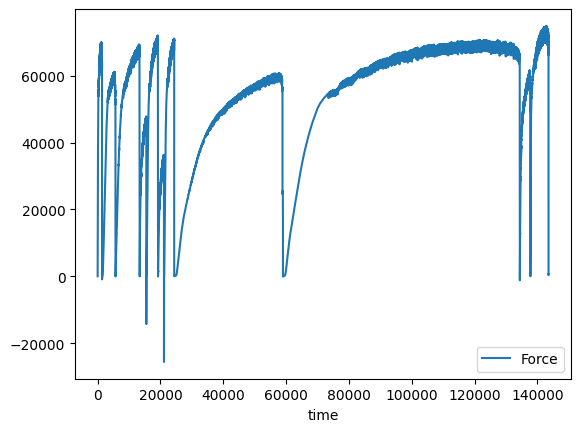

In [9]:
data_prep = Data_Prep(dataset = dat)
rnn_df, validation_df = data_prep.preprocess_rnn(date_colname = 'time', numeric_colname = 'Force', pred_set_timesteps = 50)


series_prep = Series_Prep(rnn_df =  rnn_df, numeric_colname = 'Force')
window, X_min, X_max = series_prep.make_window(sequence_length = sequence_length,
                                               train_test_split = split,
                                               return_original_x = True)

X_train, X_test, y_train, y_test = series_prep.reshape_window(window, train_test_split = split)

In [ ]:


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
#                 Building the LSTM
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ReduceLROnPlateau #Learning rate scheduler for when we reach plateaus
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)

# Reset model if we want to re-train with different splits
def reset_weights(model):
    import keras.backend as K
    session = K.get_session()
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias_initializer'):
            layer.bias.initializer.run(session=session)


# Epochs and validation split
EPOCHS = 20
validation = 0.05

# Instantiate the model
model = Sequential()

# Add the first layer.... the input shape is (Sample, seq_len-1, 1)
model.add(LSTM(
        input_shape = (sequence_length-1, 1), return_sequences = True,
        units = 100))

# Add the second layer.... the input shape is (Sample, seq_len-1, 1)
model.add(LSTM(
        input_shape = (sequence_length-1, 1),
        units = 100))

# Add the output layer, simply one unit
model.add(Dense(
        units = 1,
        activation = 'sigmoid'))

model.compile(loss = 'mse', optimizer = 'adam')


# History object for plotting our model loss by epoch
history = model.fit(X_train, y_train, epochs = EPOCHS, validation_split = validation,
          callbacks = [rlrop])
# Loss History
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
3992/3992 ━━━━━━━━━━━━━━━━━━━━ 2509s 628ms/step - loss: 0.0021 - val_loss: 1.6361e-04 - learning_rate: 0.0010
Epoch 2/20
3992/3992 ━━━━━━━━━━━━━━━━━━━━ 2548s 629ms/step - loss: 9.6649e-05 - val_loss: 6.0323e-05 - learning_rate: 0.0010
Epoch 3/20
3992/3992 ━━━━━━━━━━━━━━━━━━━━ 2509s 628ms/step - loss: 5.2649e-05 - val_loss: 3.9413e-05 - learning_rate: 0.0010
Epoch 4/20
3992/3992 ━━━━━━━━━━━━━━━━━━━━ 2541s 628ms/step - loss: 4.5170e-05 - val_loss: 2.8558e-05 - learning_rate: 0.0010
Epoch 5/20
3992/3992 ━━━━━━━━━━━━━━━━━━━━ 2546s 629ms/step - loss: 3.7534e-05 - val_loss: 1.9439e-05 - learning_rate: 0.0010
Epoch 6/20
3992/3992 ━━━━━━━━━━━━━━━━━━━━ 2531s 626ms/step - loss: 3.2565e-05 - val_loss: 2.2943e-05 - learning_rate: 0.0010
Epoch 7/20
3992/3992 ━━━━━━━━━━━━━━━━━━━━ 2547s 628ms/step - loss: 4.1608e-05 - val_loss: 1.6246e-05 - learning_rate: 0.0010
Epoch 8/20
3992/3992 ━━━━━━━━━━━━━━━━━━━━ 2542s 628ms/step - loss: 3.1891e-05 - val_loss: 1.2603e-05 - learning_rate: 0.0010
Epoc

In [ ]:
model.save('/content/Force_window.keras')  # The file needs to end with the .keras extension

In [13]:
future = Predict_Future(X_test  = X_test, validation_df = validation_df, lstm_model = model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

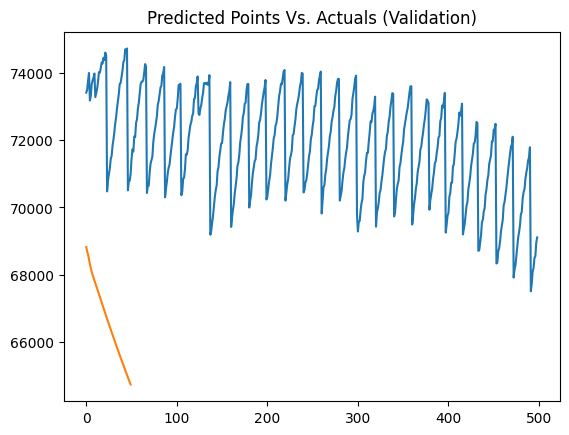

Validation Vs. Predicted
Validation    2.623001e+06
Predicted     3.331185e+06
dtype: float64


In [41]:
future.predicted_vs_actual(X_min = X_min, X_max = X_max, numeric_colname = 'Force')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

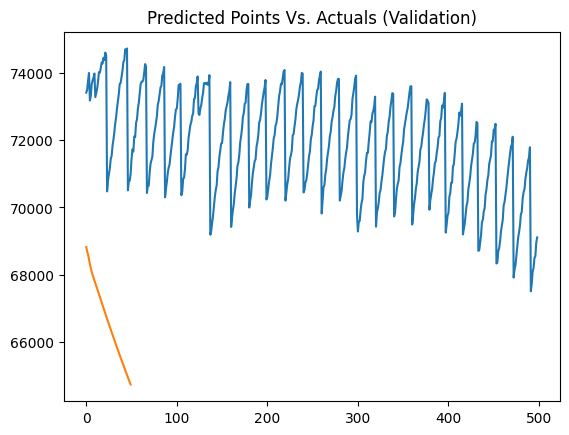

Validation Vs. Predicted
Validation    2.623001e+06
Predicted     3.331185e+06
dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
See Plot for Future Predictions


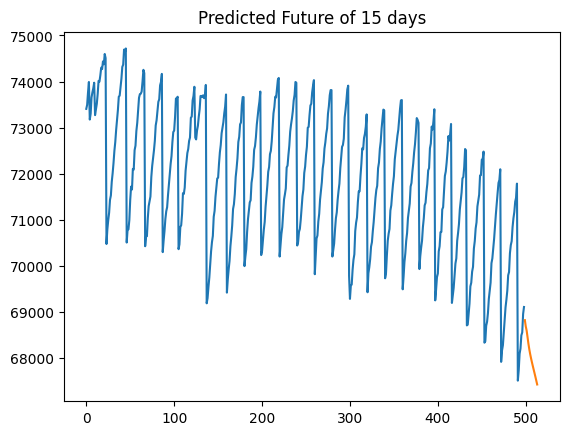

,Force,historical_flag
499,68823.764473,0
500,68689.813798,0
501,68598.780433,0
502,68461.301830,0
503,68318.339219,0
504,68195.339095,0
505,68090.345379,0
506,67998.159324,0
507,67912.633253,0
508,67831.013519,0


In [10]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
#              Predicting the future
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# Creating our future object
future = Predict_Future(X_test  = X_test, validation_df = validation_df, lstm_model = model)
# Checking its accuracy on our training set
future.predicted_vs_actual(X_min = X_min, X_max = X_max, numeric_colname = 'Force')
# Predicting 'x' timesteps out
future.predict_future(X_min = X_min, X_max = X_max, numeric_colname = 'Force', timesteps_to_predict = 50, return_future = True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━

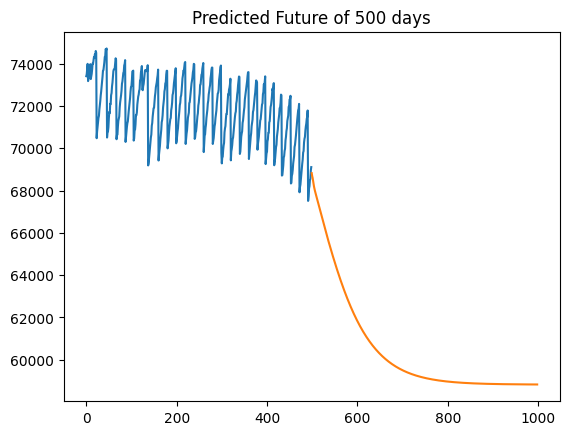

,Force,historical_flag
499,68823.764473,0
500,68689.813798,0
501,68598.780433,0
502,68461.301830,0
503,68318.339219,0
...,...,...
994,58832.577571,0
995,58832.472781,0
996,58832.367991,0
997,58832.263201,0


In [12]:
future.predict_future(X_min = X_min, X_max = X_max, numeric_colname = 'Force', timesteps_to_predict = 500, return_future = True)

In [19]:
prediction = model.predict(X_test)
print("The shape of predicted values of test data before inverse_transform: ",\
      prediction.shape)

269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
The shape of predicted values of test data before inverse_transform:  (8582, 1)


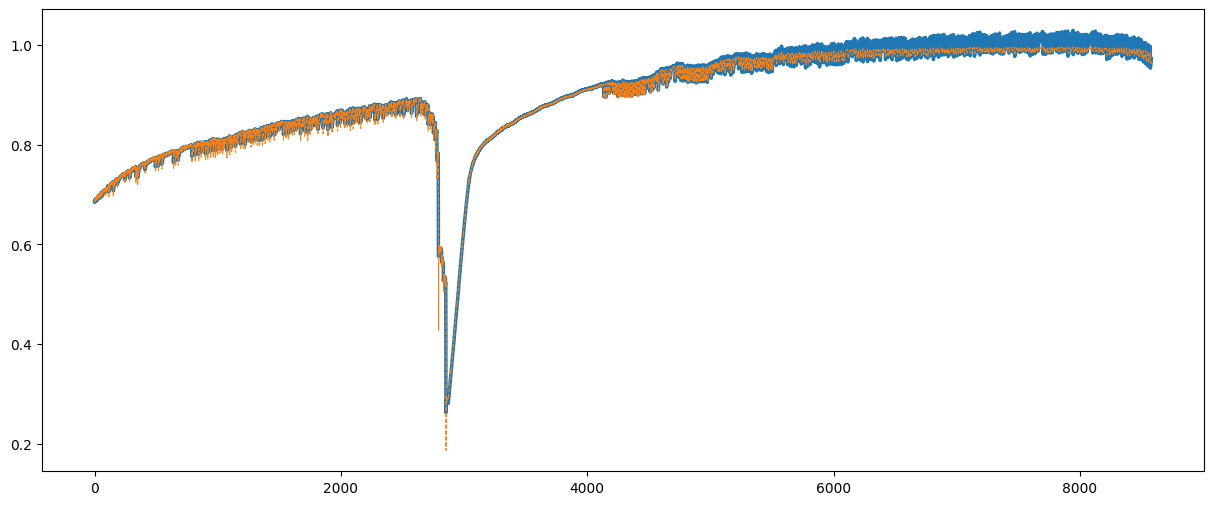

In [39]:
plt.figure(figsize=(15,6))
plt.plot(y_test, linewidth = 2.5)
plt.plot(prediction,'--',linewidth = 0.8)


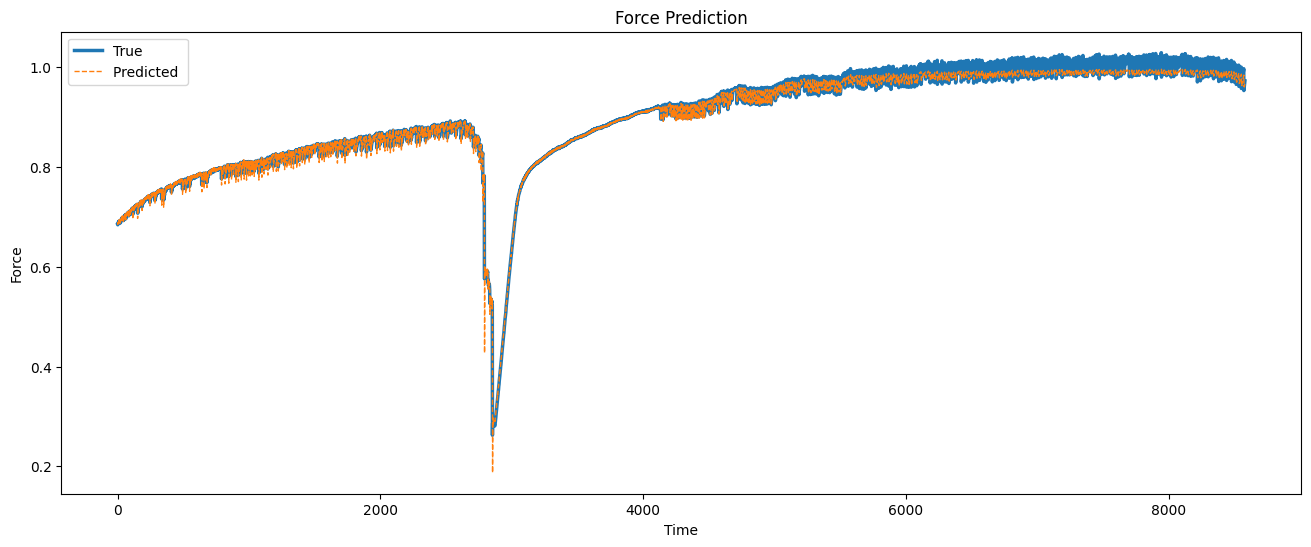

In [40]:
plt.figure(figsize=(16,6))

plt.plot(y_test, label='True',linewidth = 2.5)
plt.plot(prediction,'--', label='Predicted ',linewidth = 1)
plt.title('Force Prediction')
plt.xlabel('Time')
plt.ylabel('Force')
plt.legend()
plt.show()

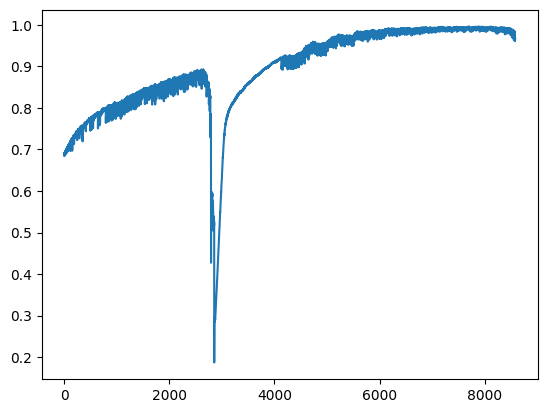

In [20]:
plt.plot(prediction)

In [27]:
len(prediction)

8582

In [28]:
len(y_test)

8582

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

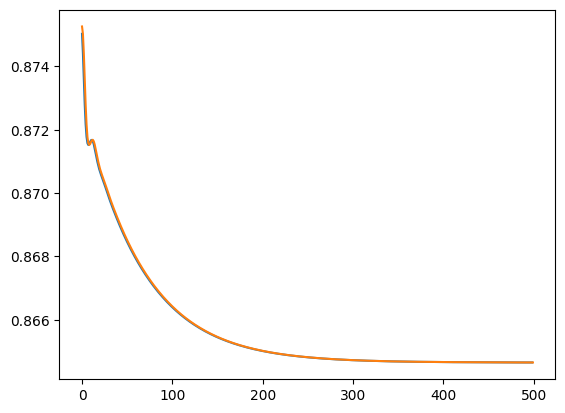

In [54]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#              Predicting the future
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
from numpy import newaxis
# We sorted descending
curr_frame = X_test[len(X_test)-6000]
future = []

# Quick plot of the frame we're predicting from
#plt.plot(curr_frame)

points_to_predict = 500
for i in range(points_to_predict):
      # append the prediction to our empty future list
     future.append(model.predict(curr_frame[newaxis,:,:])[0,0])
      # insert our predicted point to our current frame
     curr_frame = np.insert(curr_frame, len(X_test[0]), future[-1], axis=0)
      # push the frame up one to make it progress into the future
     curr_frame = curr_frame[1:]
plt.plot(curr_frame)
plt.plot(future)

In [1]:
plt.plot(X_test[len(X_test)-5999])

plt.plot(future)

NameError: name 'plt' is not defined

In [ ]:

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#              Testing the Test set
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Predict X_Test and reshape to 1D for dataframe
predictions = model.predict(X_test)
predictions = np.reshape(predictions, (predictions.size,))

# Reshape y_test to 1D for dataframe
y_test = np.reshape(y_test, (y_test.size,))

def hist_plt(pred, y):
    plt.plot(pred)
    plt.plot(y)
    plt.title('Analysis of Predictions vs Test Data')
    plt.ylabel('Volume')
    plt.xlabel('Observation #')
    plt.legend(['Predicted', 'Actual'], loc='upper right')
    plt.show()

# plot the test set vs real
hist_plt(predictions , y_test)


# Unscale
predictions_unscaled = reverse_minmax(predictions)
actuals_unscaled = reverse_minmax(y_test)
hist_plt(predictions_unscaled , actuals_unscaled)


comparison_df = pd.DataFrame({"Real": actuals_unscaled, "Pred": predictions_unscaled}, index = range(len(predictions_unscaled)))
# Print out results
print("Mean of the actuals is: {}\nMean of the predicted is: {}".format(round(comparison_df.mean()[0],3), round(comparison_df.mean()[1],3)))
print("Sum of the actuals is: {}\nSum of the predicted is: {}".format(round(comparison_df.sum()[0],4), round(comparison_df.sum()[1]),4))
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#              Testing the Training set
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# plot the train set vs real (to see if it's overtrained)
# Predict X_train
predictions_train = model.predict(X_train)
predictions_train = np.reshape(predictions_train, (predictions_train.size,))

# Get our  y_train and make 1D for df
y_train = np.reshape(y_train, (y_train.size,))

# Plot it
hist_plt(predictions_train, y_train)

comparison_df_train = pd.DataFrame({"Real_train": y_train, "Pred_train": predictions_train},  index = range(len(predictions_train)))
print("Mean of the actuals is: {}\nMean of the predicted is: {}".format(round(comparison_df_train.mean()[0],3), round(comparison_df_train.mean()[1]),3))
print("Sum of the actuals is: {}\nSum of the predicted is: {}".format(round(comparison_df_train.sum()[0],4), round(comparison_df_train.sum()[1]),4))